In [48]:
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

# DATASET (Agulhas)

In [2]:
# Find location to put data
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [12]:
PERSISTENT_BUCKET = 'gs://leap-persistent/dhruvbalwada'

In [13]:
ds_unfiltered = xr.open_zarr(PERSISTENT_BUCKET+'/ssh_reconstruction_project/unfiltered_data.zarr')
ds_filtered = xr.open_zarr(PERSISTENT_BUCKET+'/ssh_reconstruction_project/filtered_data.zarr')

In [14]:
ds_ITs = ds_unfiltered['ssh_unfiltered'] - ds_filtered['ssh_filtered']

In [15]:
ds_ITs

<xarray.DataArray (time: 70, i: 2160, j: 2160)>
dask.array<sub, shape=(70, 2160, 2160), dtype=float32, chunksize=(9, 270, 270), chunktype=numpy.ndarray>
Coordinates: (12/15)
    Depth    (j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    RAC      (j, i) float32 1.553e+06 1.553e+06 1.552e+06 ... 3.939e+06 3.94e+06
    XC       (j, i) float32 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49
    YC       (j, i) float32 -57.0 -57.0 -57.0 -57.0 ... -26.66 -26.66 -26.66
    face     int64 1
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    ...       ...
  * time     (time) timedelta64[ns] 4 days 18:00:00 ... 73 days 18:00:00
    x        (j, i) float32 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49
    x0       (i) float64 -15.49 -15.47 -15.45 -15.43 ... 29.43 29.45 29.47 29.49
    y        (j, i) float32 -57.0 -57.0 -57.0 -57.0 ... -26.66 -26.66 -26.66
    y0       (j) float64 -57.0 -56.99 -56.98 -56.97 ... -26.69 -26.68 -26.66
    z0       float64 -0.5

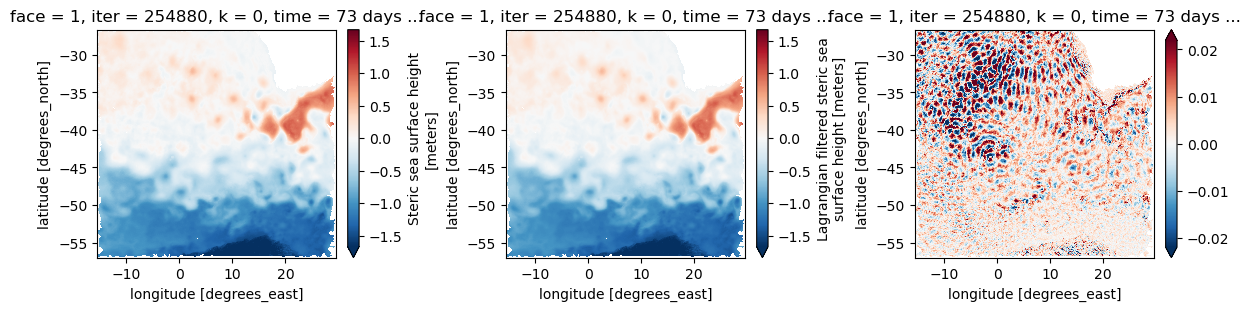

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3), constrained_layout=True)
ds_unfiltered['ssh_unfiltered'].isel(time=-1).plot(x='x0', y='y0', robust=True, ax=axes[0])
ds_filtered['ssh_filtered'].isel(time=-1).plot(x='x0', y='y0', robust= True, ax=axes[1])
ds_ITs.isel(time=-1).plot(x='x0', y='y0',robust=True, ax=axes[2])
plt.show()

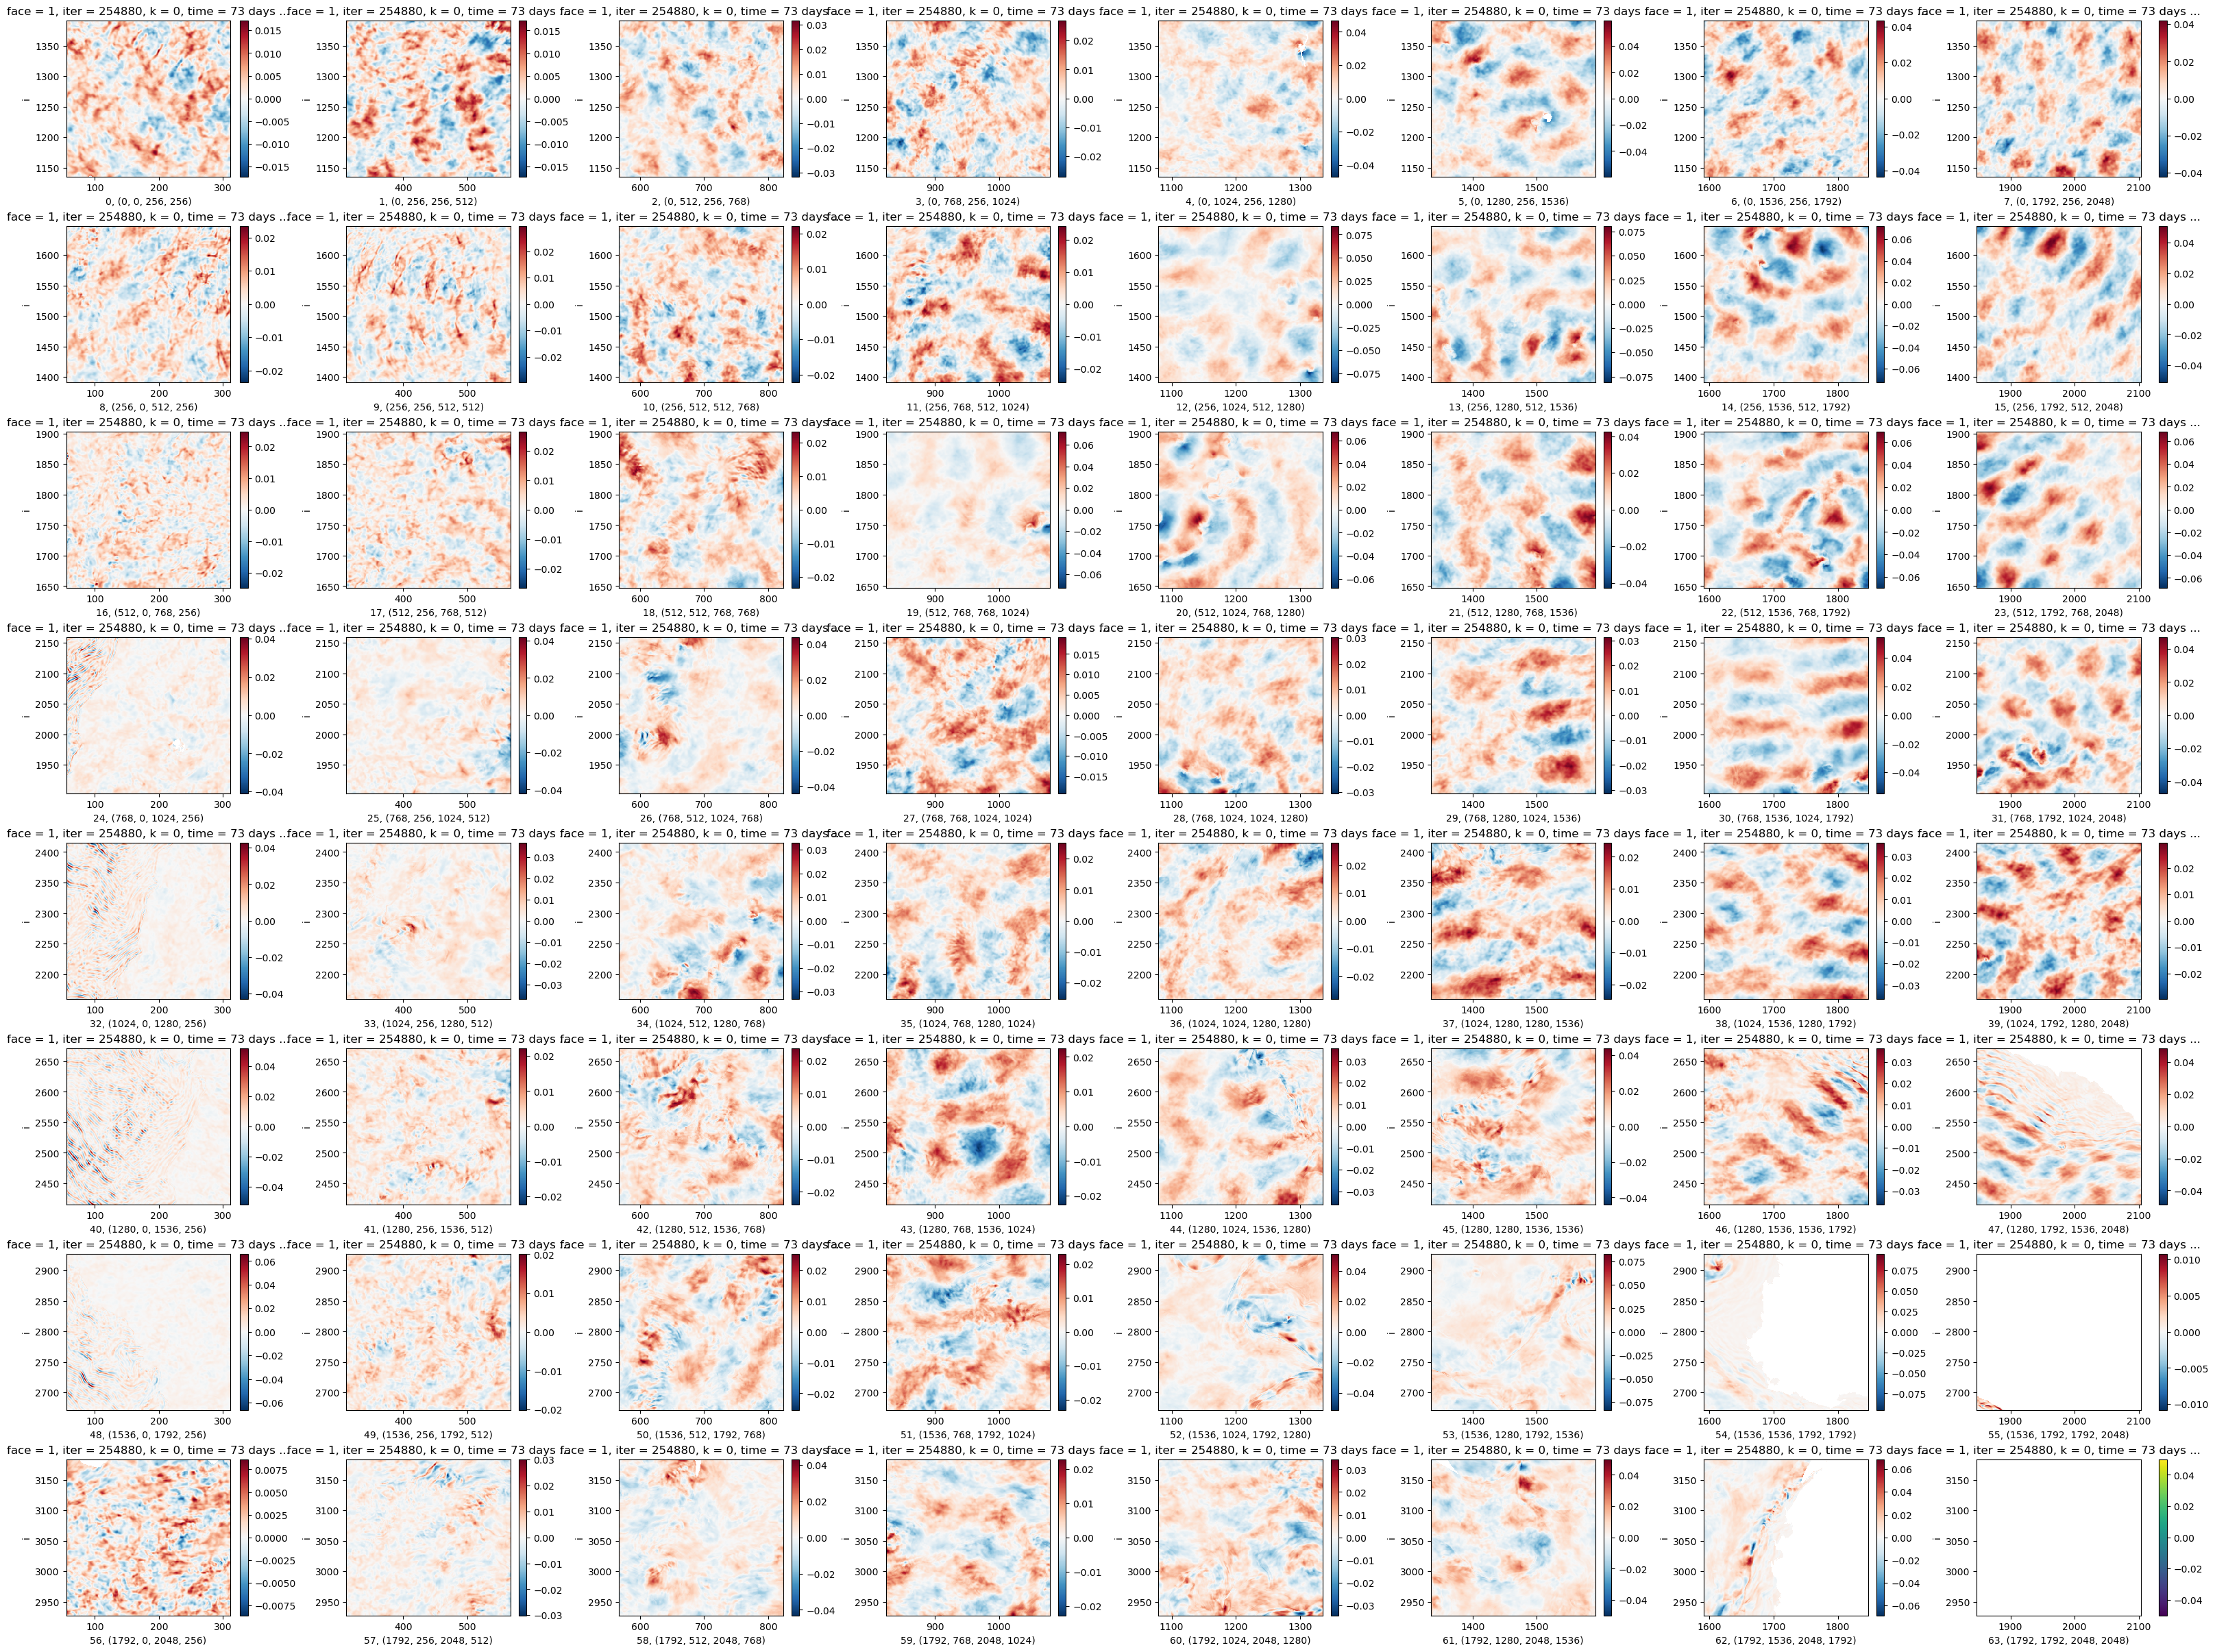

In [41]:
fig, axes = plt.subplots(ncols=8, nrows=8, figsize=(32, 24), constrained_layout=True)
for idx in range(64):
    i, j = divmod(idx, 8)
    box = (i * 256, j * 256, i * 256 + 256, j * 256 + 256)
    # print(box)
    ds_ITs[-1, 56:-56, 56:-56][box[0]:box[2], box[1]:box[3]].plot(ax=axes[i, j])
    axes[i, j].set_xlabel(f'{idx}, {box}')
plt.show()

# DATALOADER

In [133]:
# import os
import numpy as np
import torch
from torch.utils.data import Dataset
# from PIL import Image
from torchvision.transforms import Compose, ToTensor, Normalize, ColorJitter, RandomHorizontalFlip, ToPILImage

In [68]:
def crop(arr, box):
    return arr[:, box[0]:box[2], box[1]:box[3]] 

def extract_patches(arr, num_of_slice=8, crop_size=256):

    # time, rows, cols = arr.shape
    
    base = da.empty((0, 256, 256), chunks=500, dtype=float)
    for idx in range(num_of_slice**2):
        i, j = divmod(idx, num_of_slice)
        box = (i * crop_size, j * crop_size, i * crop_size + crop_size, j * crop_size + crop_size)
        if idx in [47, 54, 55, 62, 63]:
            continue
        # print(crop(arr, box).shape)
        base = da.concatenate((base, crop(arr, box)) , axis=0)
        # print(box)
    
    return base

In [72]:
extract_patches(ds_ITs[:, 56:-56, 56:-56]).shape

(4130, 256, 256)

In [ ]:
class Agulhas(Dataset):

    def __init__(self, dataset, split, joint_transform=None):
        super(Agulhas, self).__init__()
        self.dataset = dataset
        self.split = split

        self.inputs, self.targets = self._get_data_array()
        self.joint_transform = joint_transform

        mean_std = ([0.5,], [0.5,])
        self.input_transforms = Compose([ToTensor(), Normalize(*mean_std)])
        self.target_transforms = Compose([ToTensor(), Normalize(*mean_std)])

    def _get_data_array(self):
        
        import xarray as xr
        
        link1 = 'gs://leap-persistent/dhruvbalwada/ssh_reconstruction_project/unfiltered_data.zarr'
        link2 = 'gs://leap-persistent/dhruvbalwada/ssh_reconstruction_project/filtered_data.zarr'
        ds_unfiltered = xr.open_zarr(link1)
        ds_filtered = xr.open_zarr(link2)
        
        inputs = ds_unfiltered['ssh_unfiltered']
        targets = ds_unfiltered['ssh_unfiltered'] - ds_filtered['ssh_filtered']
        
        return inputs, targets

    def __getitem__(self, index):
        
        x = self.inputs.isel(time=index).values
        y = self.targets.isel(time=index).values

        if self.joint_transform:
            x, y = self.joint_transform(x, y)
        x = self.input_transforms(x)
        y = self.target_transforms(y)


        return x, y

    def __len__(self):
        return self.inputs.shape[0]
